# Prediksjon av nedbør

I denne notebooken tas det for seg ulike visualisering med tilhørende evaluringer. I andre halvdel går vi over til prediksjon og vurderer nøyaktigheten for ulike modeller.

## Felles import for alle kodeblokker

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

import ipywidgets as widgets
from IPython.display import display, clear_output

# Felles for å lage egen DF for Oslo
df_oslo = pd.read_csv("../../data/processed/vaerdata_oslo.csv")
df_oslo.columns = df_oslo.columns.str.strip()
df_oslo['elementId'] = df_oslo['elementId'].astype(str).str.strip()
df_oslo['referenceTime'] = pd.to_datetime(df_oslo['referenceTime'], errors='coerce')
df_oslo['value'] = pd.to_numeric(df_oslo['value'], errors='coerce')
df_oslo = df_oslo.dropna(subset=['value'])

## Årlig maksimumstemperatur

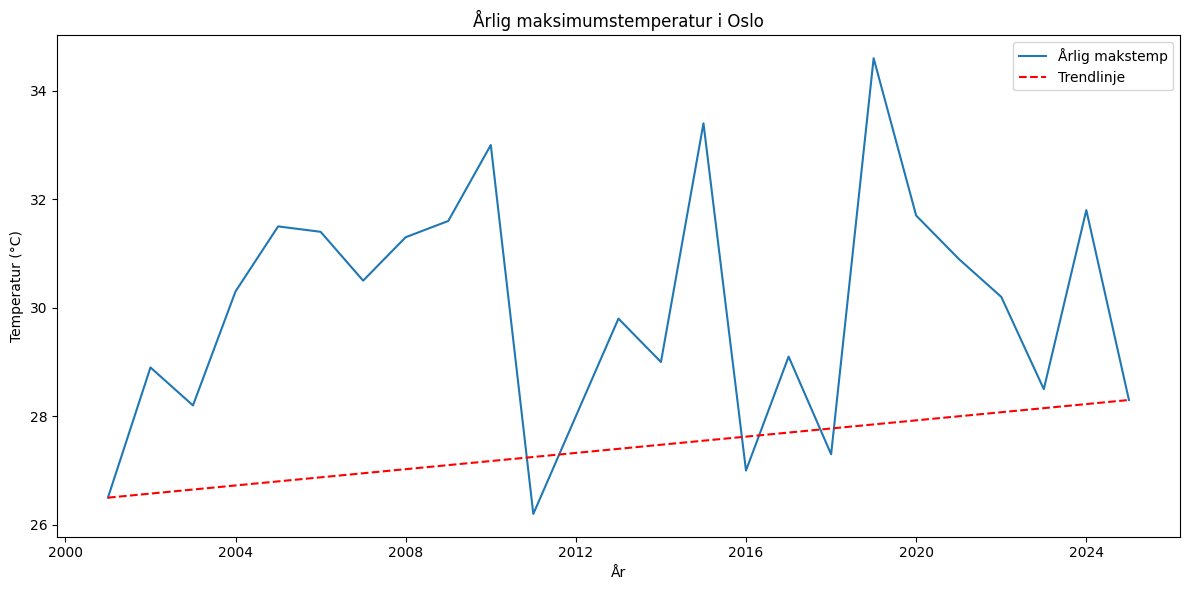

In [2]:
# Filtrer for maks temperatur
max_temp_data = df_oslo[df_oslo['elementId'] == 'max(air_temperature P1D)'].copy()
max_temp_data['value'] = pd.to_numeric(max_temp_data['value'], errors='coerce')
max_temp_data = max_temp_data.dropna(subset=['value'])

# Sett dato som index for resampling
max_temp_data.set_index('referenceTime', inplace=True)

annual_max_temp = max_temp_data['value'].resample('YE').max()


plt.figure(figsize=(12, 6))
plt.plot(annual_max_temp, label='Årlig makstemp')
plt.plot([annual_max_temp.index[0], annual_max_temp.index[-1]],
         [annual_max_temp.iloc[0], annual_max_temp.iloc[-1]],
         color='red', linestyle='--', label='Trendlinje')
plt.title('Årlig maksimumstemperatur i Oslo')
plt.ylabel('Temperatur (°C)')
plt.xlabel('År')
plt.legend()
plt.tight_layout()
plt.show()


Først kan vi visualisere endring i maks tempratur per år. Den røde trendlinjen viser at de høyeste årlige temperaturene i Oslo har hatt en svak økning over de siste 20–25 årene. Dette indikerer at de varmeste dagene i året har blitt varmere over tid, i tråd med forventninger fra klimaforskning. 

Samtidig ser vi store svingninger i de faktiske årlige makstemperaturene – fra under 27 °C enkelte år til over 34 °C i toppår som rundt 2019. Dette viser at ekstremvarme skjer uregelmessig, men at toppenivået ser ut til å ha økt over tid.



## Frekvens av maksimal

Måneden med oftest maks temperatur: 7


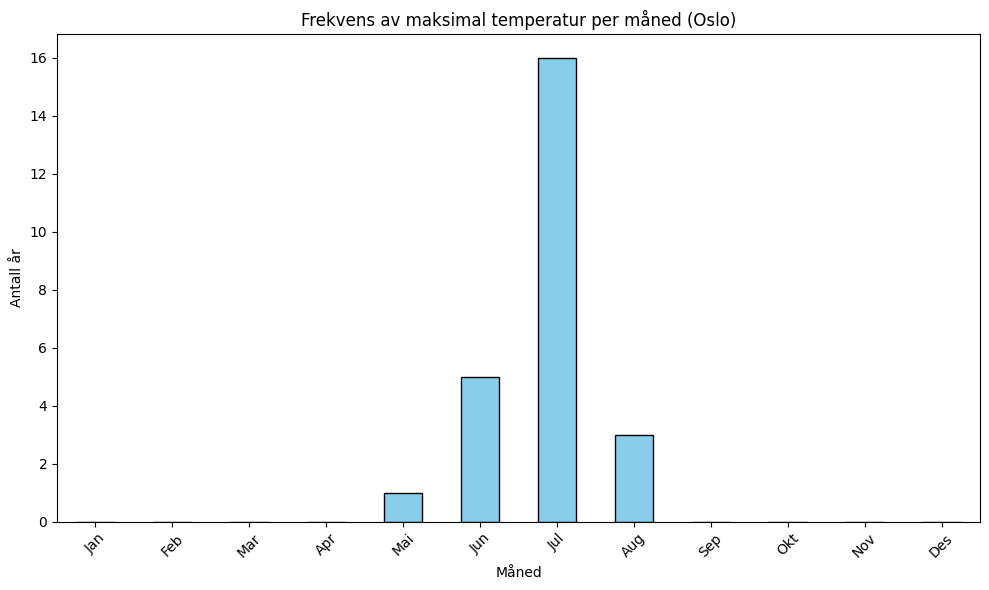

In [3]:
# Filtrer kun maks temperatur
df_max = df_oslo[df_oslo['elementId'] == 'max(air_temperature P1D)'].copy()

# Finn hvilken dato som hadde maks temperatur hvert år
df_max['year'] = df_max['referenceTime'].dt.year
max_temp_dates = df_max.loc[df_max.groupby('year')['value'].idxmax()]

# Ekstraher måneden og tell frekvenser
max_temp_months = max_temp_dates['referenceTime'].dt.month
most_common_month = max_temp_months.value_counts().idxmax()
print("Måneden med oftest maks temperatur:", most_common_month)

# Visualiser frekvens per måned
month_frequencies = max_temp_months.value_counts().sort_index()
all_months = pd.Series(0, index=np.arange(1, 13))
month_frequencies = all_months.add(month_frequencies, fill_value=0).sort_index()

plt.figure(figsize=(10, 6))
month_frequencies.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Måned')
plt.ylabel('Antall år')
plt.title('Frekvens av maksimal temperatur per måned (Oslo)')
plt.xticks(ticks=np.arange(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Des'
], rotation=45)
plt.tight_layout()
plt.show()


Denne visualiseringen viser hvilken måned som oftest har hatt årets høyeste temperatur i Oslo, basert på historiske målinger. Dataene er først filtrert til kun å inkludere maksimumstemperaturer, og deretter brukes en gruppering per år for å identifisere datoen med høyest verdi. Til slutt telles og plottes frekvensen av hvilken måned disse toppverdiene inntreffer.

Visualiseringen hjelper oss med å identifisere og synliggjøre sesongmessige mønstre i ekstrem varme. Man får bekrefte forventede resultater (som at juli har flest toppdager), og samtidig åpne for å oppdage eventuelle avvik


## Årlig minstetempratur

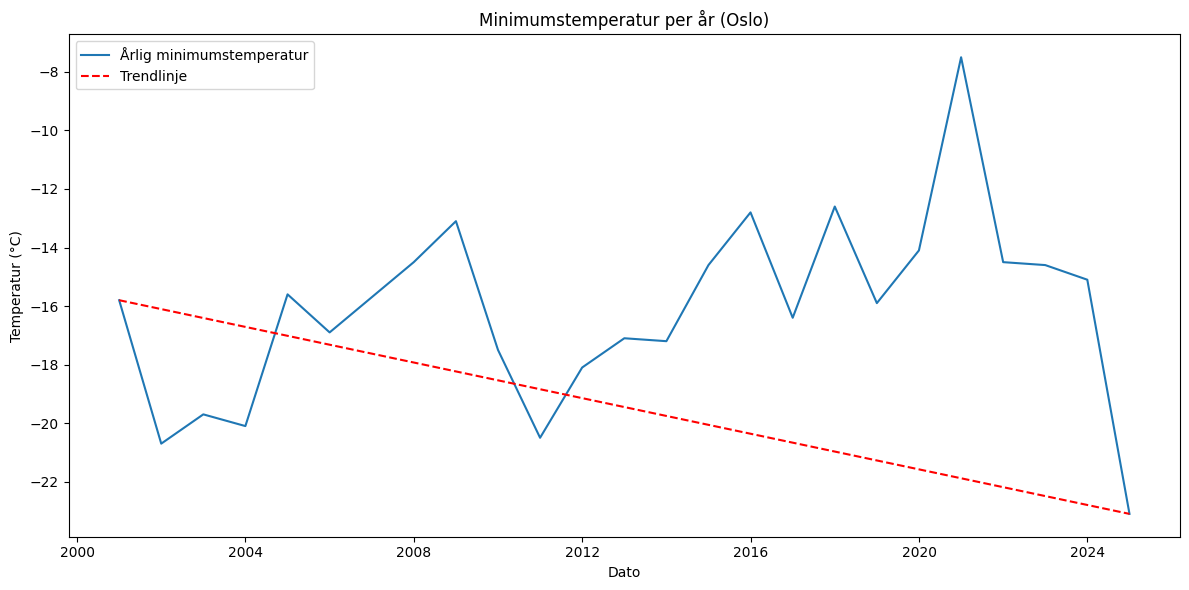

In [4]:
# Filtrer til minimum temperatur
df_min = df_oslo[df_oslo['elementId'] == 'min(air_temperature P1D)'].copy()
df_min.set_index('referenceTime', inplace=True)

# Finn årlig minimumstemperatur
min_temp = df_min['value'].resample('YE').min()


plt.figure(figsize=(12, 6))
plt.plot(min_temp, label='Årlig minimumstemperatur')
plt.plot([min_temp.index[0], min_temp.index[-1]], [min_temp.iloc[0], min_temp.iloc[-1]],
         color='red', linestyle='--', label='Trendlinje')

plt.title('Minimumstemperatur per år (Oslo)')
plt.xlabel('Dato')
plt.ylabel('Temperatur (°C)')
plt.legend()
plt.tight_layout()
plt.show()


Videre gjør vi de samme med minstetempratur. Den røde trendlinjen antyder en nedadgående utvikling, altså at minimumstemperaturene har blitt lavere over tid. Dette kan tolkes som at de kaldeste dagene i året har blitt kaldere i snitt. Selv om trenden peker ned, viser de faktiske årlige minimumstemperaturene betydelig variasjon fra år til år. Det er mange topper og bunner, og ingen jevn utvikling. Spesielt rundt 2016–2021 ser vi flere år med betydelig høyere minimumstemperaturer (mildere vintre), mens de siste årene ser ut til å være kaldere igjen.

Den negative trenden kan være påvirket av et fåtall ekstremkalde år mot slutten av serien, noe som drar ned trendlinjen. Det er ikke nødvendigvis i samsvar med global eller nasjonal oppvarming, men kan tyde på at ekstreme kuldeperioder fortsatt forekommer lokalt i Oslo, selv om gjennomsnittstemperaturene kan være på vei opp.

En lineær trend alene sier lite om klimaendringer – en glattet kurve (moving average) eller analyse av ekstremverdier kan gi mer innsikt.


Måneden hvor minimumstemperaturen oftest forekommer: 1


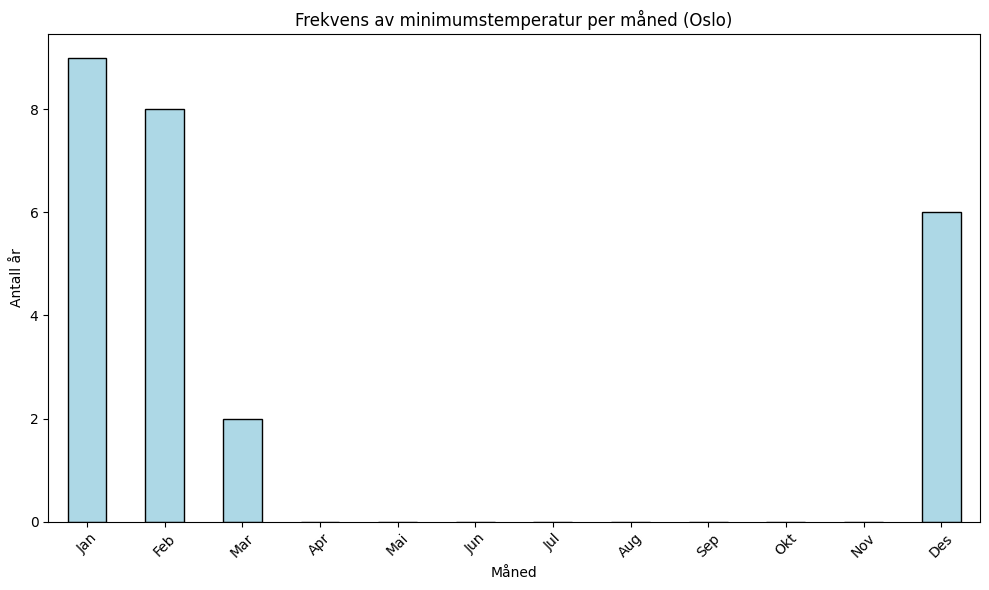

In [5]:
# Finn datoer med minimum hvert år
df_min = df_oslo[df_oslo['elementId'] == 'min(air_temperature P1D)'].copy()
df_min['referenceTime'] = pd.to_datetime(df_min['referenceTime'], errors='coerce')
df_min = df_min.dropna(subset=['value'])

df_min['year'] = df_min['referenceTime'].dt.year
min_temp_dates = df_min.loc[df_min.groupby('year')['value'].idxmin()]
min_temp_months = min_temp_dates['referenceTime'].dt.month

# Frekvenser per måned
most_common_month = min_temp_months.value_counts().idxmax()
print("Måneden hvor minimumstemperaturen oftest forekommer:", most_common_month)

month_frequencies = min_temp_months.value_counts().sort_index()
all_months = pd.Series(0, index=np.arange(1, 13))
month_frequencies = all_months.add(month_frequencies, fill_value=0).sort_index()

# Visualiser
plt.figure(figsize=(10, 6))
month_frequencies.plot(kind='bar', color='lightblue', edgecolor='black')

plt.xlabel('Måned')
plt.ylabel('Antall år')
plt.title('Frekvens av minimumstemperatur per måned (Oslo)')
plt.xticks(ticks=np.arange(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Des'
], rotation=45)
plt.tight_layout()
plt.show()


Vi gjør det samme med minstetempratur og som forventet faller også de kaldeste målingene på vintermånedene

### Faglig refleksjon
Disse analysene illustrerer viktigheten av å se ytterpunkter for å forstå klimaendringer. Ekstremverdiene har stor praktisk betydning – fra energibehov til helseberedskap – og bør inngå i helhetlige vurderinger av klimaets utvikling.

Funnenene viser også hvorfor det er viktig å ikke basere konklusjoner på trendligninger alene, særlig over kortere tidsperioder og med variabelt datagrunnlag. Det illustrerer også at klimaanalyse krever kombinasjon av statistikk og fagforståelse – og bør suppleres med analyser av maks- og minimumsanalyser



## Logistisk regresjon og Naive Byes-modellen

I dette steget skal det implementeres to maskinlæringsmodeller for å forutsi været, nærmere bestemt hvorvidt det vil regne eller ikke, basert på maksimums- og minimumstemperaturen. Prediksjonsmodellene er to vanlige klassifikasjonsalgoritmer/modeller.

For prediksjonen splittes datasettet i et treningssett og et testsett. Treningssettet brukes til å trene modellene, mens testsettet brukes til å sjekke hvor gode modellene er for å predikere nye data. Størrelsen på treningssettet er 80%, mens testsettet da blir 20%. Grunnlaget for akkurat den fordelingen er at det er generelt akseptert (Sivakumar et al., 2024) som en balansert fordeling/split. Om datasettet hadde vært mindre kunne man vurderte å bruke en større andel for trening slik at modellen får mer data til å tyde mønstre i.

### Logistisk regresjon

In [ ]:
# Filtrer ut relevante målinger fra df_oslo
df_max = df_oslo[df_oslo['elementId'] == 'max(air_temperature P1D)'][['referenceTime', 'value']].rename(columns={'value': 'TMAX'})
df_min = df_oslo[df_oslo['elementId'] == 'min(air_temperature P1D)'][['referenceTime', 'value']].rename(columns={'value': 'TMIN'})

# Slå sammen de to
df_combined = pd.merge(df_max, df_min, on='referenceTime', how='inner')

# Legg til nedbør hvis du har det – her antar vi du har elementId = 'sum(precipitation_amount P1D)'
df_rain = df_oslo[df_oslo['elementId'] == 'sum(precipitation_amount P1D)'][['referenceTime', 'value']].rename(columns={'value': 'RAIN'})
df_combined = pd.merge(df_combined, df_rain, on='referenceTime', how='inner')

# Lag en binær kolonne for regn: 1 hvis det regnet, ellers 0
df_combined['RAIN'] = (df_combined['RAIN'] > 0).astype(int)

# Dropp evt. manglende verdier
df_combined = df_combined.dropna()

# Feature og label
X = df_combined[['TMAX', 'TMIN']]
y = df_combined['RAIN']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelltrening
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Prediksjon og evaluering
y_pred = model.predict(X_test_scaled)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[3459 1674]
 [1511 3554]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.67      0.68      5133
           1       0.68      0.70      0.69      5065

    accuracy                           0.69     10198
   macro avg       0.69      0.69      0.69     10198
weighted avg       0.69      0.69      0.69     10198



#### Evaluering av logistisk regresjon
Denne modellen klarer å predikere 3459 true positive verdier og 3554 true negative verdier. Modellen er 69% nøyaktig.

### Naive Byes

In [7]:
model2 = GaussianNB()
model2.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model2.predict(X_test_scaled)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[2307 2826]
 [1326 3739]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.45      0.53      5133
           1       0.57      0.74      0.64      5065

    accuracy                           0.59     10198
   macro avg       0.60      0.59      0.58     10198
weighted avg       0.60      0.59      0.58     10198



#### Evaluering av Naive Byes

Denne modellen klarer å predikere 2307 true positive verdier og 3739 true negative verdier. Modellen er 59% nøyaktig.

Ettersom logistisk regresjon er mer nøyaktig enn Naive Byes, benyttes førstnevnte til å predikere den nye dataen.

### Prediksjon av nåtid
Vi kan forutsi regn ved å predikere nedbørsmengden basert på maksimums- og minimumstemperaturen. Hvis nedbøren er positiv, vil det regne; ellers vil det ikke regne. For å forutsi nedbørsmengden kan en enkel lineær regresjon med to funksjoner (maksimums- og minimumstemperatur) gjøre jobben.

In [8]:
# Filtrer for relevant timeOffset og relevante målinger
df_oslo = df_oslo[df_oslo['timeOffset'] == 'PT18H']
df_oslo = df_oslo[df_oslo['elementId'].isin([
    'max(air_temperature P1D)',
    'min(air_temperature P1D)',
    'sum(precipitation_amount P1D)'
])]

# Gjør om referenceTime til dato og pivotér
df_oslo['date'] = pd.to_datetime(df_oslo['referenceTime']).dt.date
df_oslo_pivot = df_oslo.pivot_table(index='date', columns='elementId', values='value').dropna()

# Gi enkle kolonnenavn
df_oslo_pivot.columns = ['TMAX', 'TMIN', 'PRCP']  # i riktig rekkefølge etter elementId

X = df_oslo_pivot[['TMAX', 'TMIN']]
y = df_oslo_pivot['PRCP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

new_data = pd.DataFrame({'TMAX': [5], 'TMIN': [-2]})
new_prediction = model.predict(new_data)

print("\nPrediksjon for ny data:", new_prediction)

if new_prediction[0] > 0:
    print("Det kommer til å regne ")
else:
    print("Det blir ikke regn ")


Mean Squared Error: 23.9126597174319
R² Score: 0.11489291556720393

Prediksjon for ny data: [1.52755065]
Det kommer til å regne 


#### Mean Squared Error

Modellen fikk en Mean Squared Error (MSE) på 23.91. MSE måler den gjennomsnittlige kvadrerte forskjellen mellom de faktiske og predikerte verdiene. Dette tallet alene sier lite uten kontekst, men dersom nedbøren i datasettet typisk ligger i området 0–20 mm, er dette et relativt høyt avvik. For å sette det i perspektiv; så er kvadratroten av 23,91 i underkant av 5 mm. Dette betyr at den gjennomsnittlige forskjellen mellom de faktiske nedbørsmengdene og de predikerte verdiene er omtrent 5 mm.

Det antyder at modellen har utfordringer med å forutsi presise nedbørsmengder, noe som ikke er overraskende med så få forklaringsvariabler.

#### R²-score

Modellen har en R²-score på 0.11, noe som betyr at modellen forklarer kun 11 % av variasjonen i nedbøren. Dette er en lav verdi og tyder på at maksimum- og minimumstemperatur alene ikke er tilstrekkelige for å forklare eller predikere nedbørsmengder på en presis måte. Det er rimelig, da nedbør også påvirkes av faktorer som lufttrykk, vindretning, fuktighet og topografi.

For nye temperaturdata (TMAX = 5, TMIN = -2) predikerte modellen en nedbørsmengde på 1.53 mm. Ettersom denne verdien er over 0, konkluderer modellen med at det vil komme regn. Dette er i tråd med realistiske værforhold, da slike temperaturer ofte er forbundet med lett regn eller sludd, spesielt i byer som Oslo.

#### Konklusjon
Modellen fungerer OK til å gi et grovt estimat om det kommer til å regne eller ikke.



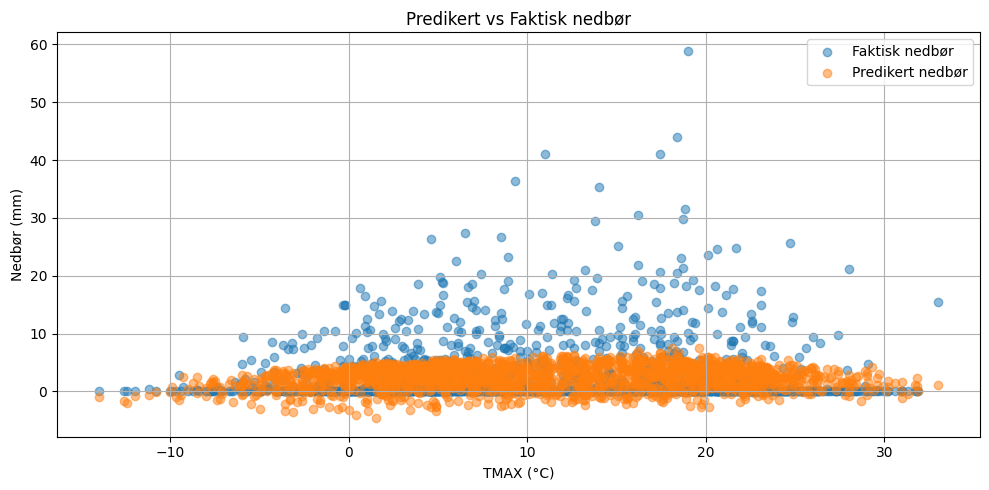

In [9]:
plt.figure(figsize=(10, 5))
plt.scatter(X_test['TMAX'], y_test, label='Faktisk nedbør', alpha=0.5)
plt.scatter(X_test['TMAX'], y_pred, label='Predikert nedbør', alpha=0.5)
plt.xlabel('TMAX (°C)')
plt.ylabel('Nedbør (mm)')
plt.title('Predikert vs Faktisk nedbør')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
tmax_slider = widgets.FloatSlider(value=5, min=-20, max=35, step=0.5, description='Legg inn maksimumstemperatur (°C)')
tmin_slider = widgets.FloatSlider(value=-2, min=-30, max=25, step=0.5, description='Legg inn minimumstemperatur (°C)')
button = widgets.Button(description='Prediker nedbør')

output = widgets.Output()

def on_button_click(b):
    with output:
        clear_output()
        new_input = pd.DataFrame({'TMAX': [tmax_slider.value], 'TMIN': [tmin_slider.value]})
        prediction = model.predict(new_input)[0]
        print(f"Predikert nedbør: {prediction:.2f} mm")
        if prediction > 0:
            print("Det vil sannsynligvis regne")
        else:
            print("Det vil sannsynligvis ikke regne")

button.on_click(on_button_click)

display(tmax_slider, tmin_slider, button, output)


FloatSlider(value=5.0, description='Legg inn maksimumstemperatur (°C)', max=35.0, min=-20.0, step=0.5)

FloatSlider(value=-2.0, description='Legg inn minimumstemperatur (°C)', max=25.0, min=-30.0, step=0.5)

Button(description='Prediker nedbør', style=ButtonStyle())

Output()

## Kilder

Sivakumar, M., Parthasarathy, S., & Padmapriya, T. (2024). Trade-off between training and testing ratio in machine learning for medical image processing. PeerJ Computer Science, 10, e2245. https://doi.org/10.7717/peerj-cs.2245